# Preamble

## Packages

In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd
from scipy.stats import chi2
from scipy.special import sph_harm
import healpy as hp
from healpy.sphtfunc import map2alm

%matplotlib inline
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# np.set_printoptions(edgeitems=3, linewidth=200) 
# pd.set_option('display.max_columns', None)
# pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

## Units and constants

# Power spectrum of data

## Load data

In [3]:
# Load quasars into a DataFrame
quasars_pd = pd.read_csv("../data/quasars_phot.csv")

In [4]:
quasars_pd.columns.values

array(['source_id', 'parallax', 'parallax_error', 'ra', 'dec', 'ra_error',
       'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmra_pmdec_corr', 'astrometric_gof_al',
       'astrometric_matched_observations', 'visibility_periods_used',
       'astrometric_sigma5d_max', 'radial_velocity',
       'radial_velocity_error', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_weight_al',
       'astrometric_chi2_al', 'matched_observations', 'phot_g_mean_mag',
       'phot_bp_rp_excess_factor'], dtype=object)

In [5]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values
pmra = quasars_pd['pmra'].values
pmdec = quasars_pd['pmdec'].values
pmra_error = quasars_pd['pmra_error']
pmdec_error = quasars_pd['pmdec_error']
pm_var = 0.5*(pmra_error**2 + pmdec_error**2)

In [6]:
quasars_icrs = SkyCoord(ra=ra*u.deg, 
                        dec=dec*u.deg, 
                        pm_ra_cosdec=pmra*u.mas/u.yr, 
                        pm_dec=pmdec*u.mas/u.yr, 
                        frame='icrs')
quasars_gal = quasars_icrs.transform_to('galactic')

In [7]:
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value
pm_b_gal = quasars_gal.pm_b.value

## Healpix binning

### Data binning

In [8]:
nside = 32
npix = hp.nside2npix(nside)
lmax = 25 #3*nside-1
print('npix =', npix, ', lmax =', lmax, end=None)
#map = np.arange(npix)
#hp.mollview(map, title="Mollview image RING", xsize=2000)

q_pix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))

pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

quasars_map = np.zeros(hp.nside2npix(nside))
pm_N_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))

npix = 12288 , lmax = 25


In [9]:
for idx, ipix in enumerate(tqdm_notebook((q_pix))):
    quasars_map[ipix] += 1
    pm_N_map[ipix] += 1/pm_var[idx]
    pm_l_map[ipix] += pm_l_gal[idx]/pm_var[idx]
    pm_b_map[ipix] += pm_b_gal[idx]/pm_var[idx]

pm_l_map /= (pm_N_map + 10**(-15))
pm_b_map /= (pm_N_map + 10**(-15))
pm_mag_map = np.sqrt(pm_l_map**2 + pm_b_map**2)
pm_N_map = np.reciprocal(pm_N_map + 10**(-15))

#### plots

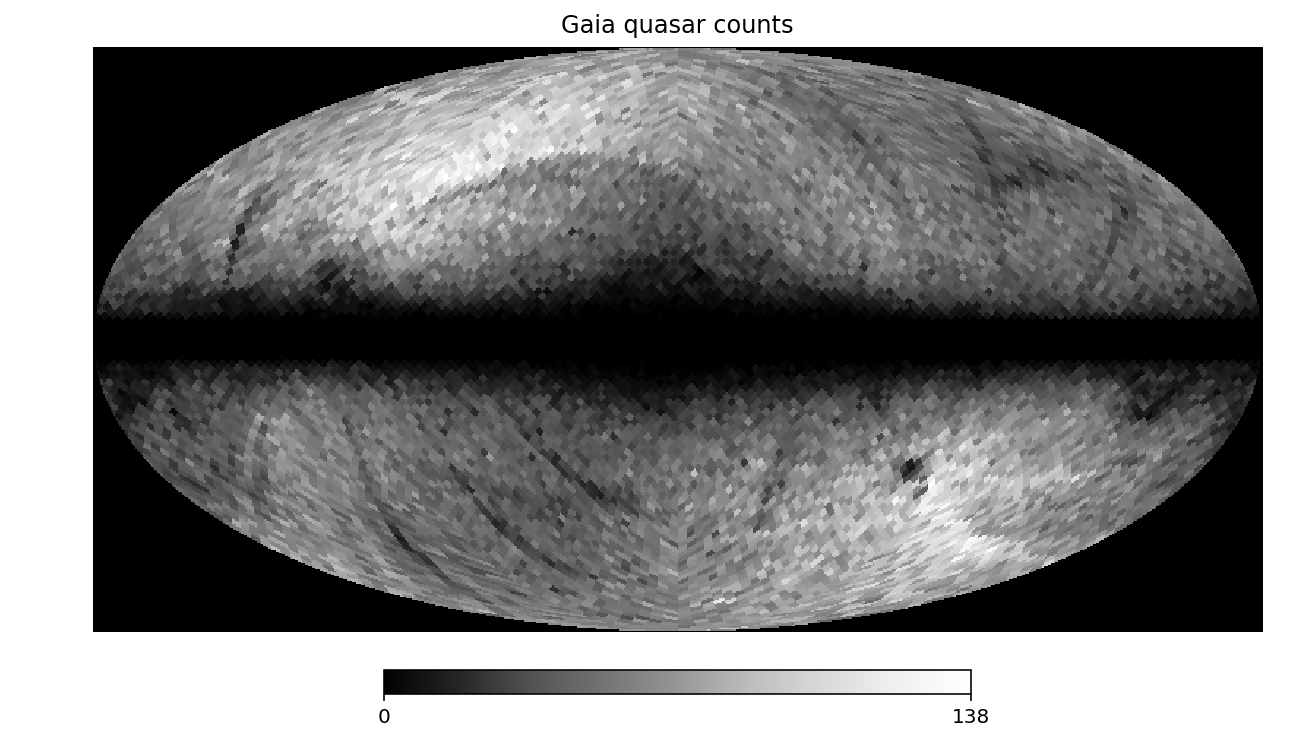

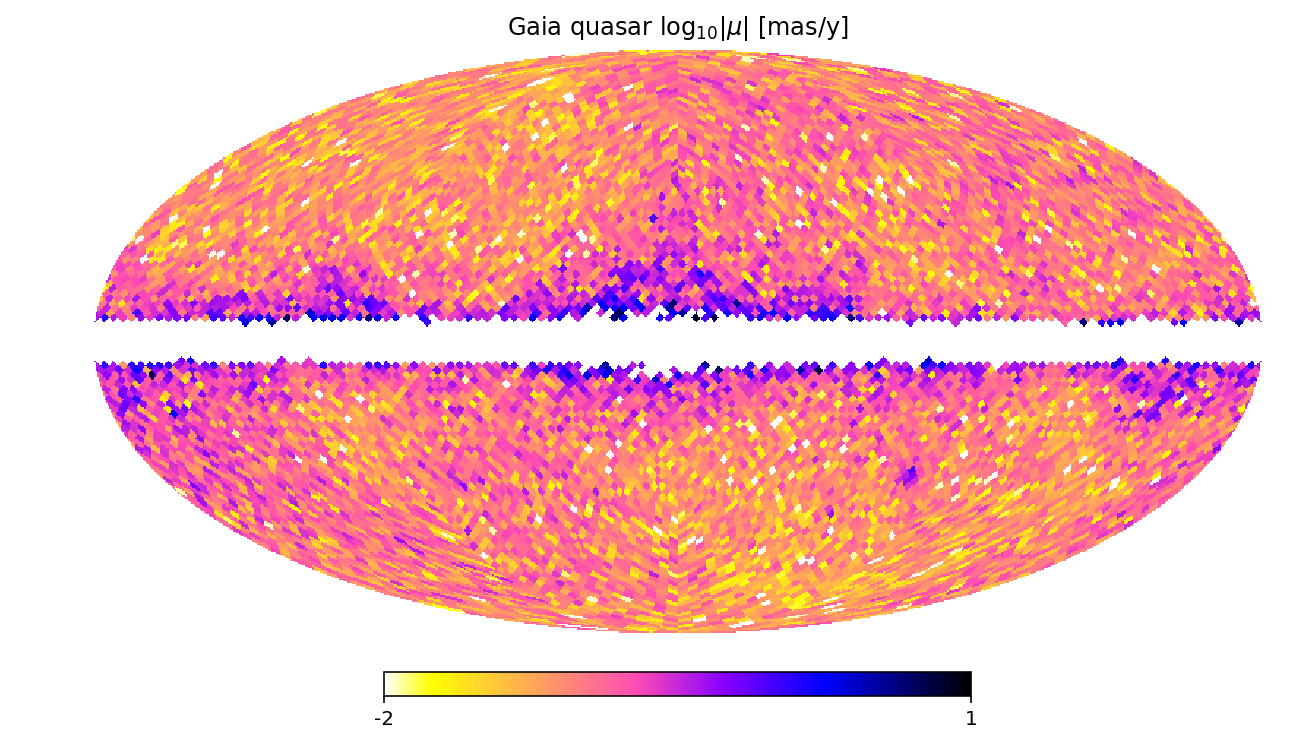

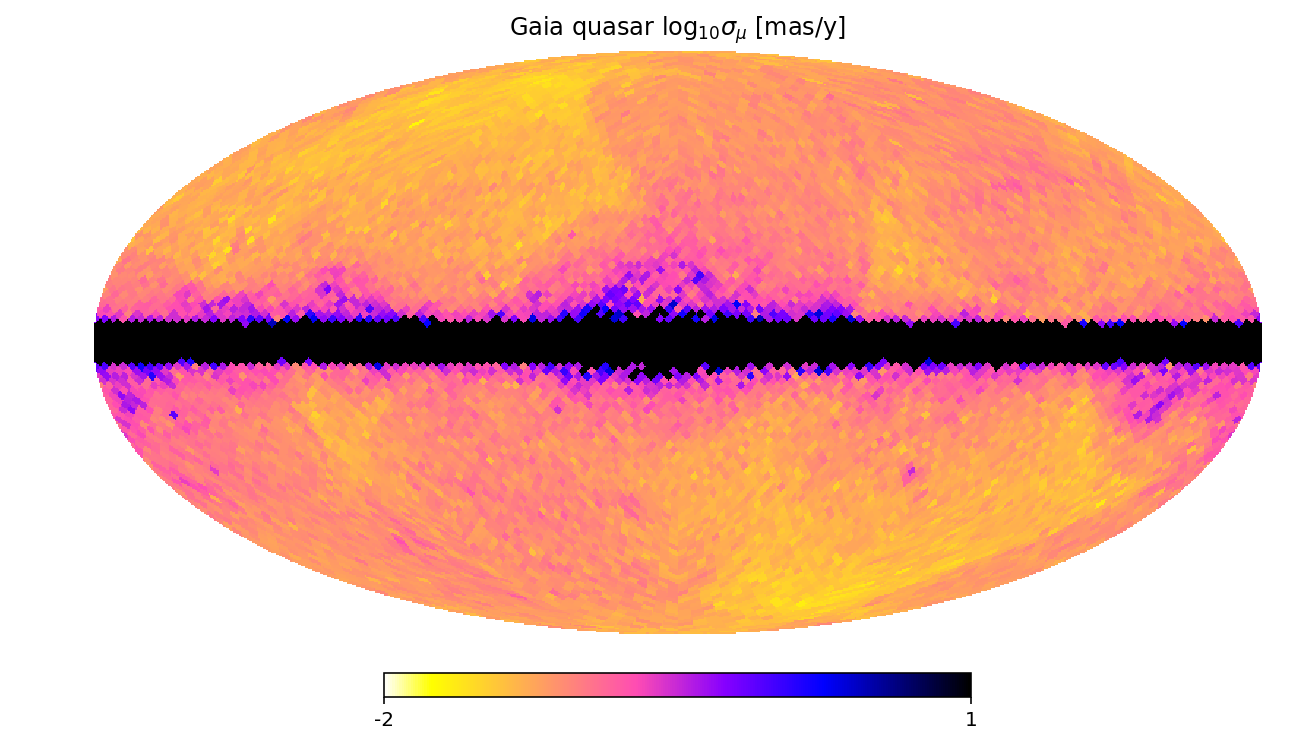

In [10]:
fig_quasars_map = hp.mollview(quasars_map, title="Gaia quasar counts", min=0,cmap='Greys_r')
plt.savefig('quasars_map.pdf', figsize=(8,6), dpi=300)
fig_quasars_pm_mag_map = hp.mollview(np.log10(pm_mag_map+10**(-100)), title="Gaia quasar $\log_{10} |\mu|$ [mas/y]", min=-2, max=1,cmap='gnuplot2_r')
plt.savefig('quasars_pm_mag_map.pdf', figsize=(8,6), dpi=300)
fig_quasars_pm_N_map = hp.mollview(np.log10(np.sqrt(pm_N_map)), title="Gaia quasar $\log_{10} \sigma_\mu$ [mas/y]", min=-2, max=1,cmap='gnuplot2_r')
plt.savefig('quasars_pm_N_map.pdf', figsize=(8,6), dpi=300)

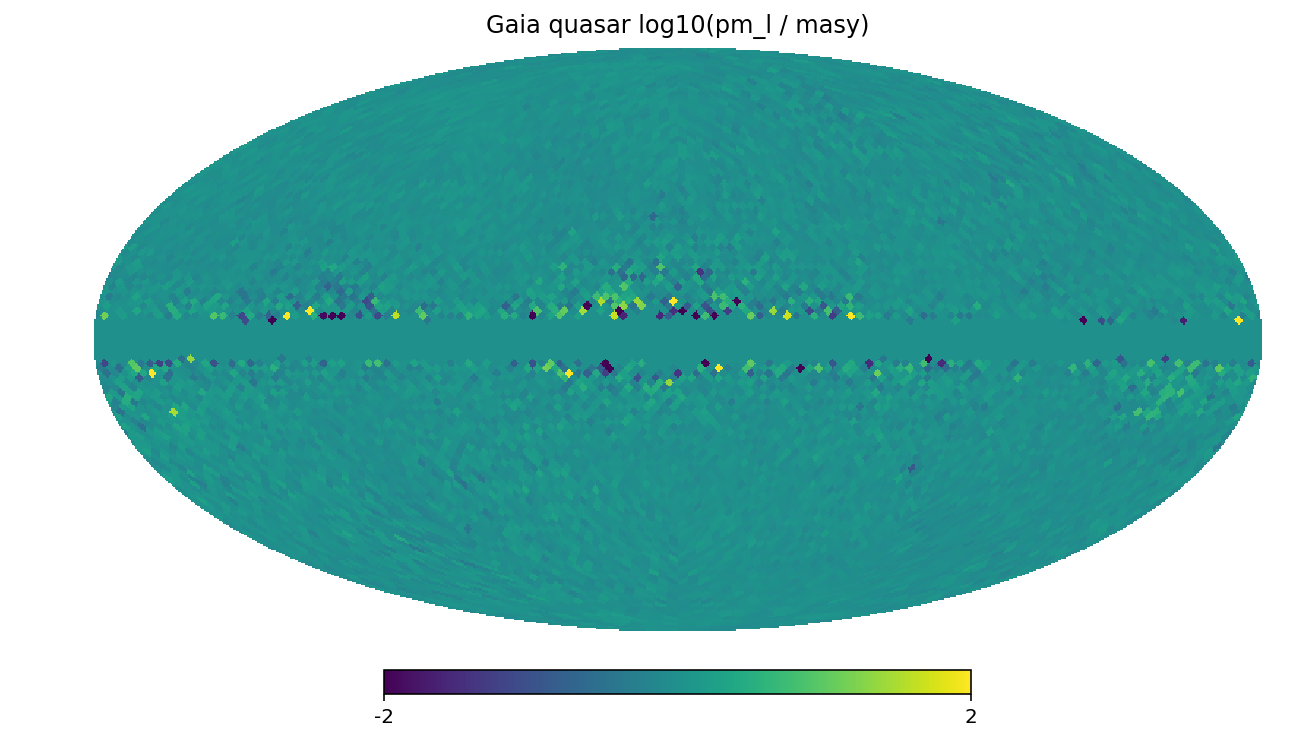

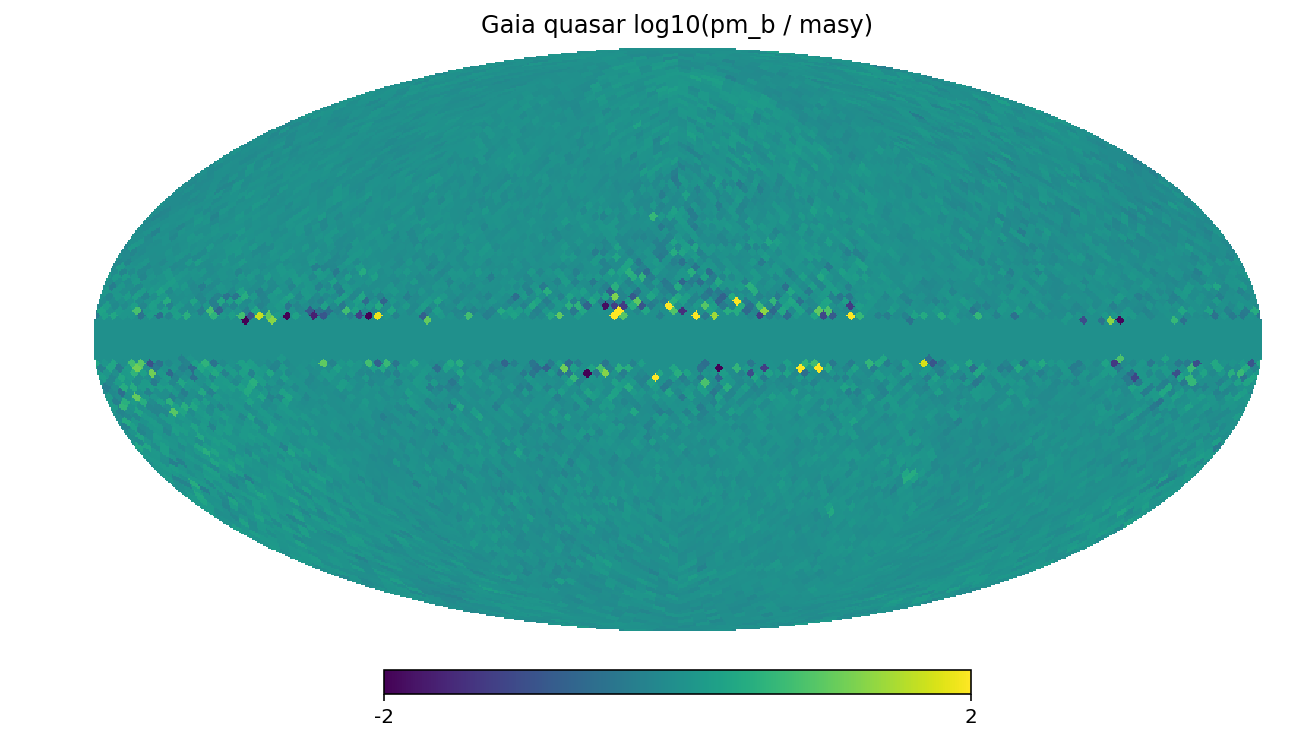

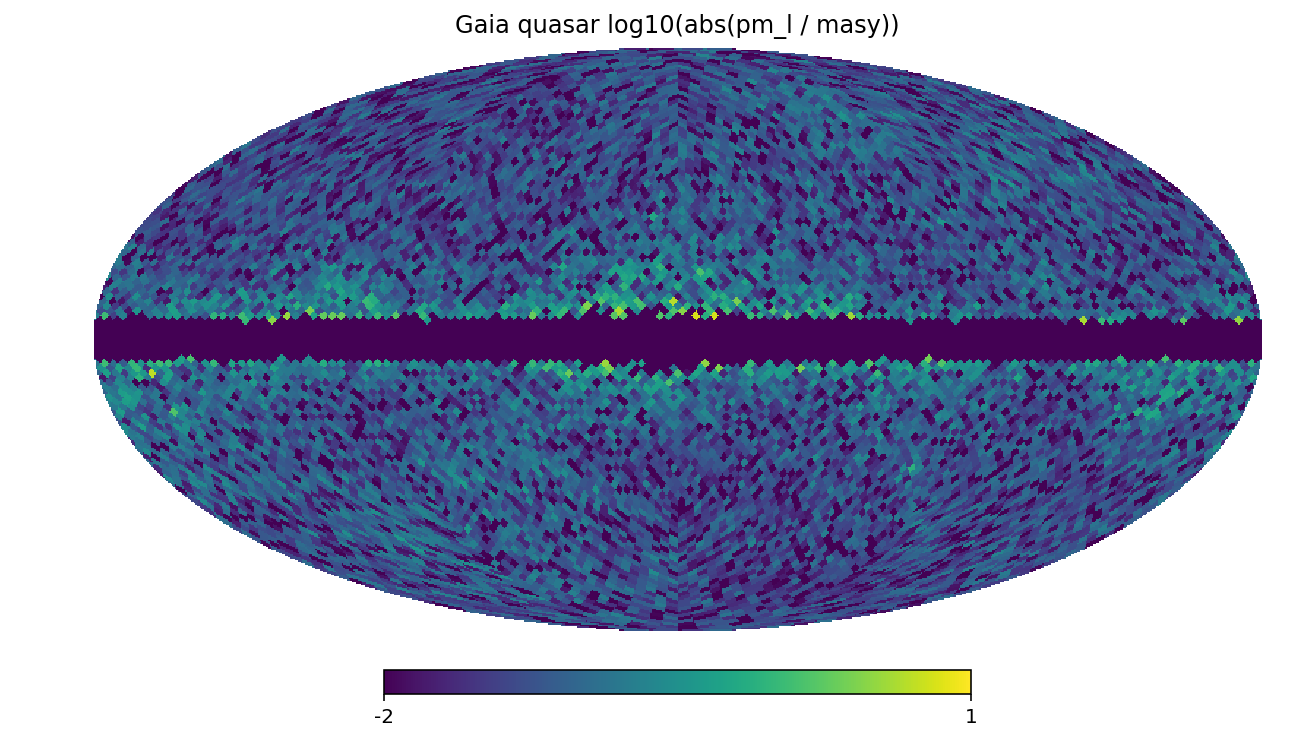

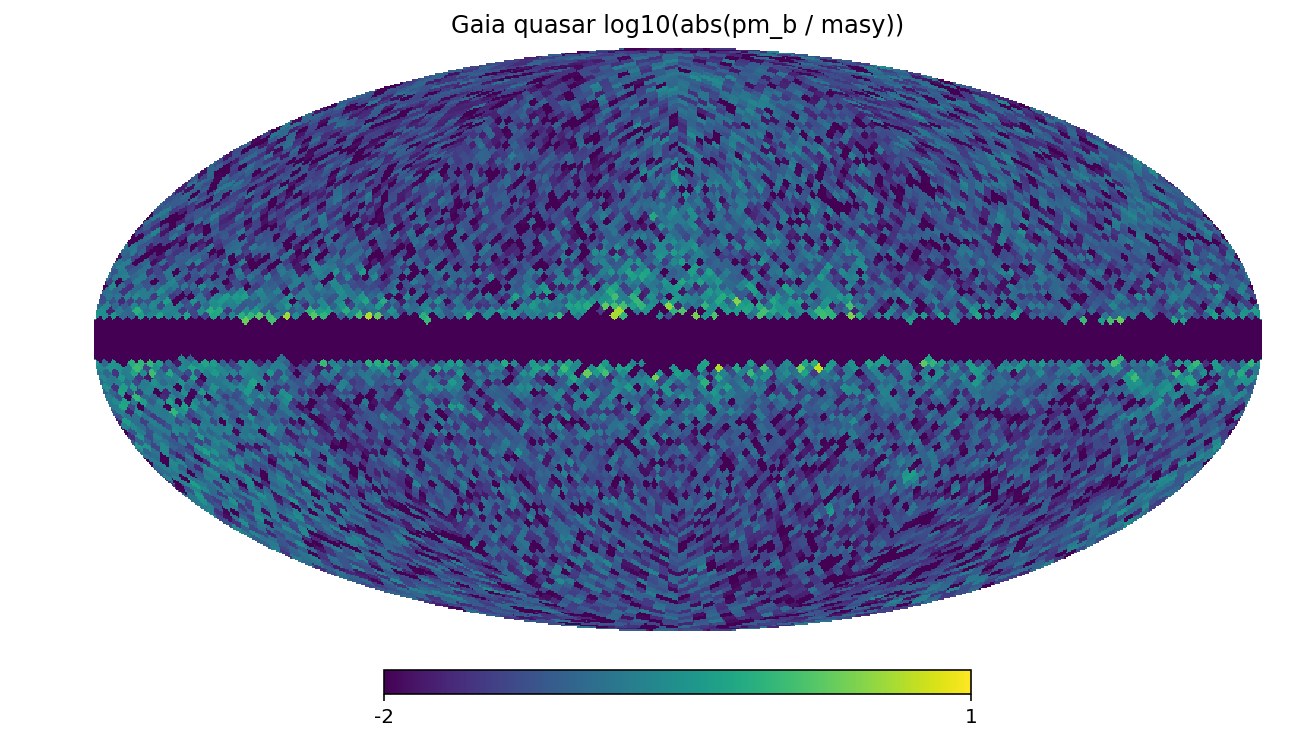

In [11]:
hp.mollview(pm_l_map, title="Gaia quasar log10(pm_l / masy)", min=-2, max=2)
hp.mollview(pm_b_map, title="Gaia quasar log10(pm_b / masy)", min=-2, max=2)
hp.mollview(np.log10(abs(pm_l_map)+10**(-6)), title="Gaia quasar log10(abs(pm_l / masy))",min=-2,max=1)
hp.mollview(np.log10(abs(pm_b_map)+10**(-6)), title="Gaia quasar log10(abs(pm_b / masy))",min=-2,max=1)

### Harmonic binning functions

In [12]:
#note: scipy's spherical harmonics have theta and phi reversed, and have n = ell.  
#For example, sph_harm(m, n, theta, phi) in scipy is sph_harm(m, ell, phi, theta) in the standard notation
#Convert to standard notation
from mpmath import spherharm
def Yharm(l,m,theta,phi):
    return sph_harm(m,l,phi,theta)
    
#this runs much slower but is capable of going to much higher ell...
# def Yharm(l,m,theta,phi):
#     return complex(spherharm(l,m,theta,phi))

def Yharm_map(l,m):
    """spherical harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    for i in np.arange(npix):
        tmp_map[i] += Yharm(l,m,pix_coords[i,0],pix_coords[i,1])
        
    return tmp_map

In [13]:
from healpy.sphtfunc import Alm

def alm_getidx(lmax,l,m):
    if m >= 0:
        return Alm.getidx(lmax,l,m)
    else:
        return round(0.5*lmax**2 + 1.5*lmax + 1) - (lmax+1) + Alm.getidx(lmax,l,abs(m))
    
def alm_getlm(lmax,idx):
    if idx < round(0.5*lmax**2 + 1.5*lmax + 1):
        return Alm.getlm(lmax,idx)
    else:
        lm_pos =  Alm.getlm(lmax, idx - round(0.5*lmax**2 + 1.5*lmax + 1) + (lmax+1))
        return (lm_pos[0], -lm_pos[1])

In [14]:
def complexmap2alm(map):
    alm_real = map2alm(np.real(map))
    alm_imag = map2alm(np.imag(map))
    alm_total = alm_real + alm_imag*1j
    for idx_lower in range(lmax+1, alm_real.size):
        alm_total = np.concatenate(( alm_total, [(-1)**Alm.getlm(lmax,idx_lower)[1] * (alm_real[idx_lower]-alm_imag[idx_lower]*1j)] ))    
    return alm_total

## Scalar power spectrum $|\mu|$

### Fisher matrix computation

$$ F_{\ell m \ell' m'} = \frac{1}{2} \sum_{i j} \frac{P^{\ell m}_{ij} P^{\ell' m'}_{ji}}{N_i N_j} = \frac{1}{2} \sum_{i j} f^{\ell m}_{i}  Y^{\ell' m' *}_{i}  f^{\ell' m' *}_j Y^{\ell m }_{j} = \frac{1}{2} f_{\ell' m'}^{\ell m} f_{\ell m}^{\ell' m'} $$
$(\ell m)$ Fourier amplitude of $f^{\ell' m'}_i \equiv \frac{Y^{\ell' m'}_i}{ N_i}$ is $f_{\ell m}^{\ell' m'}$

In [15]:
def mat_Fisher_amp(weights_map):
    mat_f = np.zeros(((lmax+1)**2,(lmax+1)**2), dtype='complex')
    for idx in tqdm_notebook(range((lmax+1)**2)):
        l = alm_getlm(lmax,idx)[0].item()
        m = alm_getlm(lmax,idx)[1].item()
        mat_f[idx] += complexmap2alm(Yharm_map(l,m)*weights_map)

    return mat_f

In [16]:
def mat_Fisher(weights_map):
    mat_amp = mat_Fisher_amp(weights_map)
    return mat_amp * np.conjugate(mat_amp)

In [17]:
def mat_Fisher_inv(weights_map):
    return np.real(np.linalg.inv(mat_Fisher(weights_map)))

In [18]:
def mat_Fisher_amp2inv(amp):
    return np.real(np.linalg.inv(amp * np.conjugate(amp)))

In [19]:
lmax = 3*nside-1

In [26]:
hp.anafast(Yharm_map(22,15))

/home/sm8383/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:222: ComplexWarning: Casting complex values to real discards the imaginary part
  pixel_weights_filename=pixel_weights_filename,


array([2.88103360e-37, 1.84147061e-35, 1.57236183e-19, 7.43637656e-35,
       5.09833094e-19, 1.37863825e-34, 1.02544413e-18, 3.44067101e-34,
       1.65712996e-18, 7.51866959e-35, 2.34764653e-18, 6.09916057e-35,
       3.03702889e-18, 2.91525167e-34, 3.67307500e-18, 1.04742217e-33,
       4.22484795e-18, 4.02661433e-33, 4.70357186e-18, 3.91126858e-33,
       5.19147084e-18, 4.85991320e-33, 1.11111111e-02, 3.57714830e-33,
       7.06826862e-18, 1.43315998e-33, 9.27826257e-18, 1.13678864e-33,
       1.32006795e-17, 6.16142314e-34, 1.97172892e-17, 6.06335928e-34,
       2.99288492e-17, 5.90519082e-34, 4.50878182e-17, 2.64017145e-33,
       6.66367487e-17, 3.17896085e-33, 9.62513914e-17, 1.36326719e-33,
       1.36003277e-16, 1.63270295e-33, 1.88646831e-16, 2.31207333e-33,
       2.58058700e-16, 1.63436170e-33, 3.49912683e-16, 6.51917934e-34,
       4.72336620e-16, 6.37182105e-34, 6.36541205e-16, 7.92526368e-34,
       8.57451846e-16, 6.86344086e-34, 1.15424134e-15, 6.32618862e-34,
      

In [135]:
matfishamp = mat_Fisher_amp(0.5*pm_N_map**(-1)) #weighted by inverse variance of |mu|

KeyboardInterrupt: 

In [ ]:
matfishinv = mat_Fisher_amp2inv(matfishamp) 
matfishinv

In [ ]:
fig_matfishinv = plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log(abs(matfishinv)), vmin=-22, cmap = 'gnuplot2_r');
plt.suptitle('inverse Fisher matrix', fontsize=12)
plt.xlabel('$(\ell,m)$ index', fontsize=12)
plt.ylabel('$(\ell,m)$ index', fontsize=12)
plt.colorbar()
plt.show()
fig_matfishinv.savefig('matfishinv.pdf')

In [ ]:
# compare average *diagonal* element to average element
print(np.trace(matfishinv)/matfishinv.shape[1])
print(sum(sum(matfishinv))/matfishinv.size)

### Weighted numerator noise computation

Noise piece:
$$ \sum_i \frac{P^{\ell m}_{i i}}{N_i} = f^{\ell m}_{\ell m} $$

In [ ]:
def mat_num_noise(weights_map):
    return np.real(np.diagonal(mat_Fisher_amp(weights_map)))

In [ ]:
def mat_num_noise_from_amp(amp):
    return np.real(np.diagonal(amp))

In [ ]:
matnumnoise = mat_num_noise_from_amp(matfishamp)
matnumnoise;

In [ ]:
(matnumnoise.mean() / matnumnoise.std())

### Weighted numerator signal computation

Signal piece:
$$ \sum_{ij} \frac{d_i}{N_i} \frac{d_j}{N_j} P^{\ell m}_{ij} = |\tilde{d}_{\ell m}|^2 $$
where $\tilde{d}_{\ell m}$ is the $(\ell m)$ Fourier amplitude of $\tilde{d_i} \equiv \frac{d_i}{N_i}$

In [ ]:
def mat_num_sig(data_map,weights_map):
    dtilde_lm = complexmap2alm(data_map*weights_map)
    return np.real(dtilde_lm * np.conjugate(dtilde_lm))

In [ ]:
matnumsig = mat_num_sig(pm_mag_map,0.5*pm_N_map**(-1))

In [ ]:
(matnumsig.mean(),matnumsig.std())

In [ ]:
def arr_pow_spec(pow_spec):
    tmp_mat = np.zeros((lmax+1,lmax+1))+10**(-100)
    for l in range(lmax+1):
        for m in range(l+1):
            idx = alm_getidx(lmax,l,m)
            tmp_mat[m,l] += pow_spec[idx]
    
    return tmp_mat

In [ ]:
plt.figure(num=None, figsize=(6,4), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(arr_pow_spec(matnumsig))),  origin='lower', vmin=-2, vmax=2, cmap = 'gnuplot2_r');
#plt.suptitle('$\log_{10}S_{\ell m} [(\mu \mathrm{as}/\mathrm{y})^2]$', fontsize=12)
plt.suptitle('numerator signal', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()

### Normalized power spectrum

In [ ]:
powspec = matfishinv @ (matnumsig - matnumnoise)
(powspec.mean(), powspec.std());

In [ ]:
powspec = matfishinv @ matnumsig

In [ ]:
arrpowspec = arr_pow_spec(powspec)
arrpowspec;

In [ ]:
fig_powspec = plt.figure(num=None, figsize=(6,4), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(arrpowspec)),  origin='lower', vmin=-7, vmax=-3, cmap='gnuplot2_r');
plt.suptitle('$\log_{10}S_{\ell m} [(\mu \mathrm{as}/\mathrm{y})^2]$', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()
fig_powspec.savefig('powspec.pdf')